In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Red Wine Quality

In [3]:
#https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
dataset = pd.read_csv("data/winequality-red.csv")

In [4]:
dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
dataset.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [7]:
dataset.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

### Распределение переменных

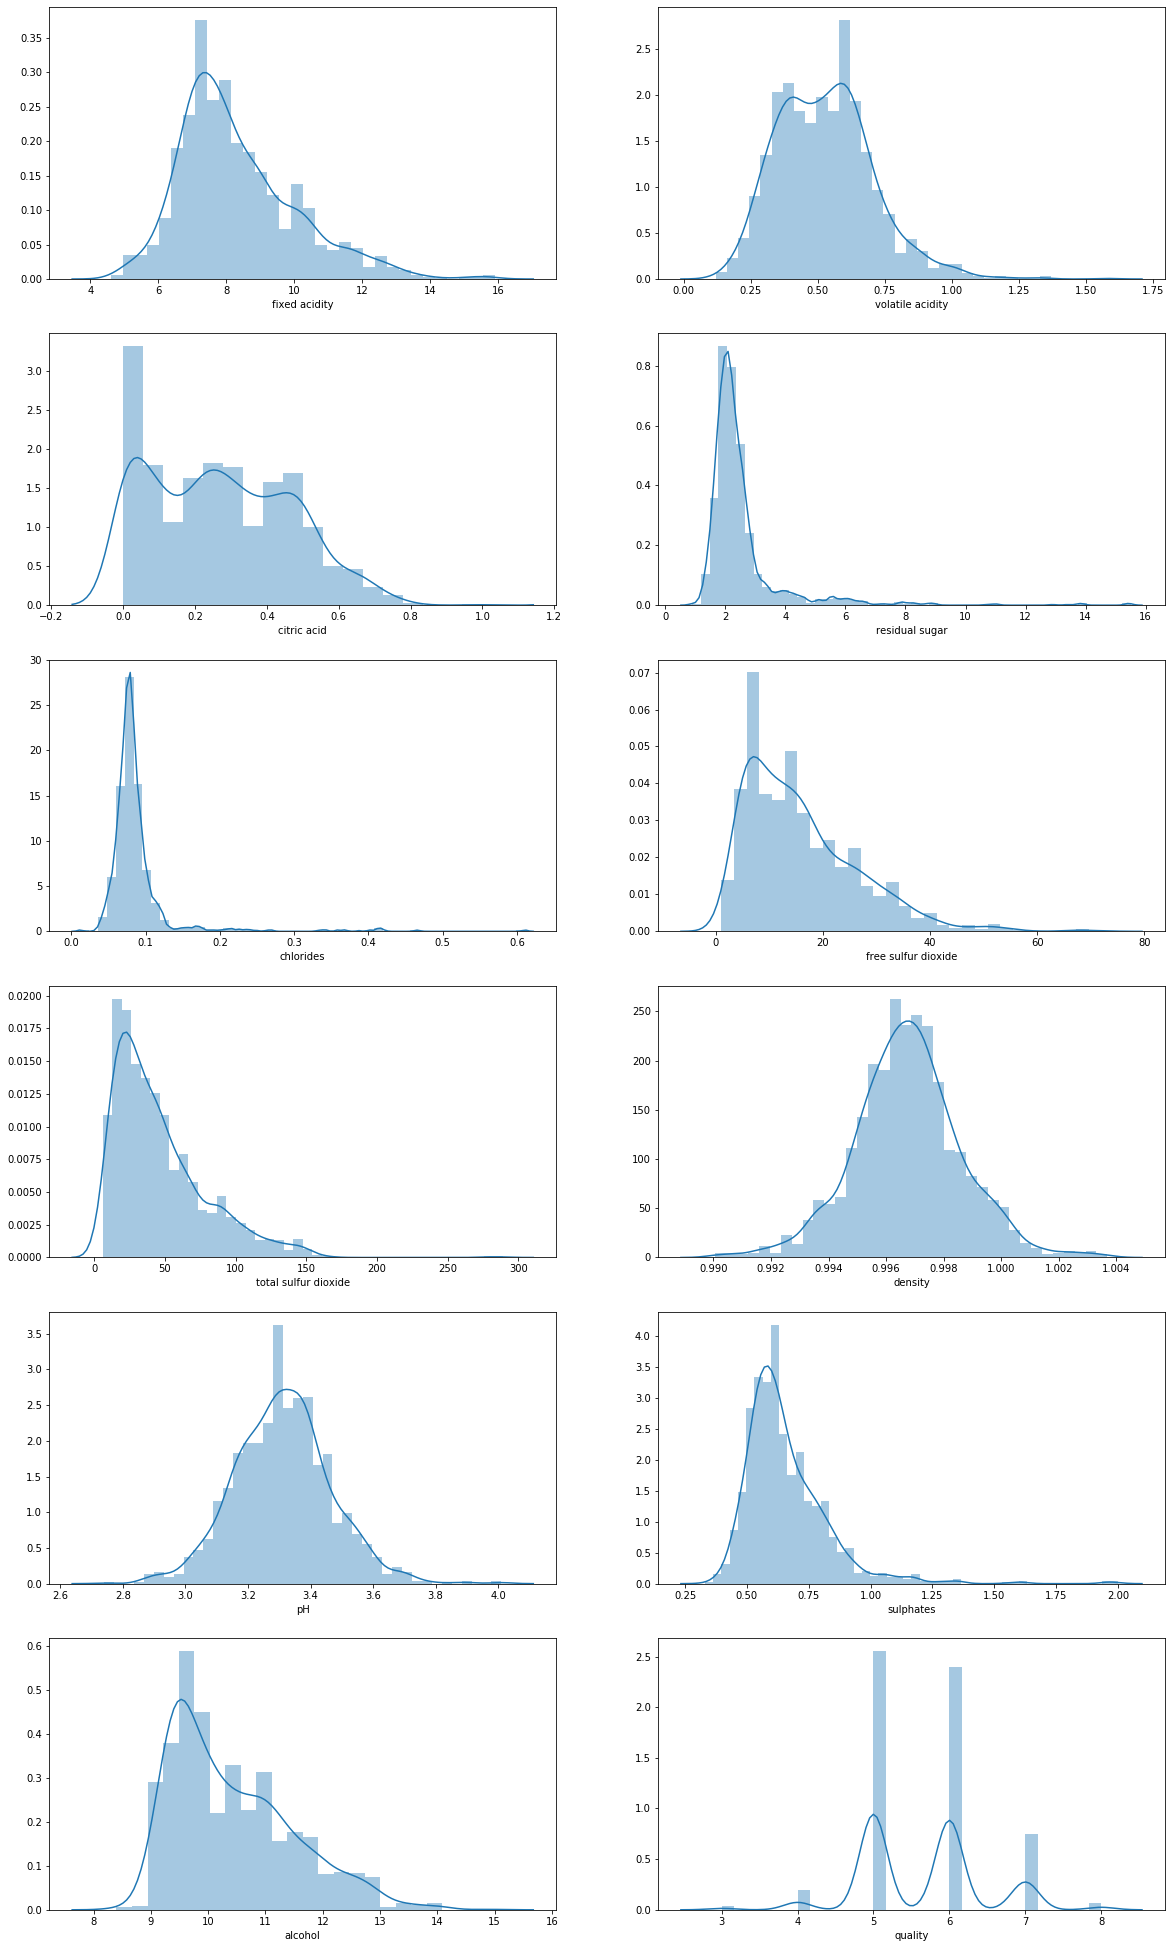

In [8]:
f, axes = plt.subplots(6, 2, figsize=(20, 35))
sns.distplot(dataset.iloc[:,0], ax=axes[0, 0])
sns.distplot(dataset.iloc[:,1], ax=axes[0, 1])
sns.distplot(dataset.iloc[:,2], ax=axes[1, 0])
sns.distplot(dataset.iloc[:,3], ax=axes[1, 1])
sns.distplot(dataset.iloc[:,4], ax=axes[2, 0])
sns.distplot(dataset.iloc[:,5], ax=axes[2, 1])
sns.distplot(dataset.iloc[:,6], ax=axes[3, 0])
sns.distplot(dataset.iloc[:,7], ax=axes[3, 1])
sns.distplot(dataset.iloc[:,8], ax=axes[4, 0])
sns.distplot(dataset.iloc[:,9], ax=axes[4, 1])
sns.distplot(dataset.iloc[:,10], ax=axes[5, 0])
sns.distplot(dataset.iloc[:,11], ax=axes[5, 1])

### Корреляция 

Text(0.5, 1, 'Корреляция между признаками')

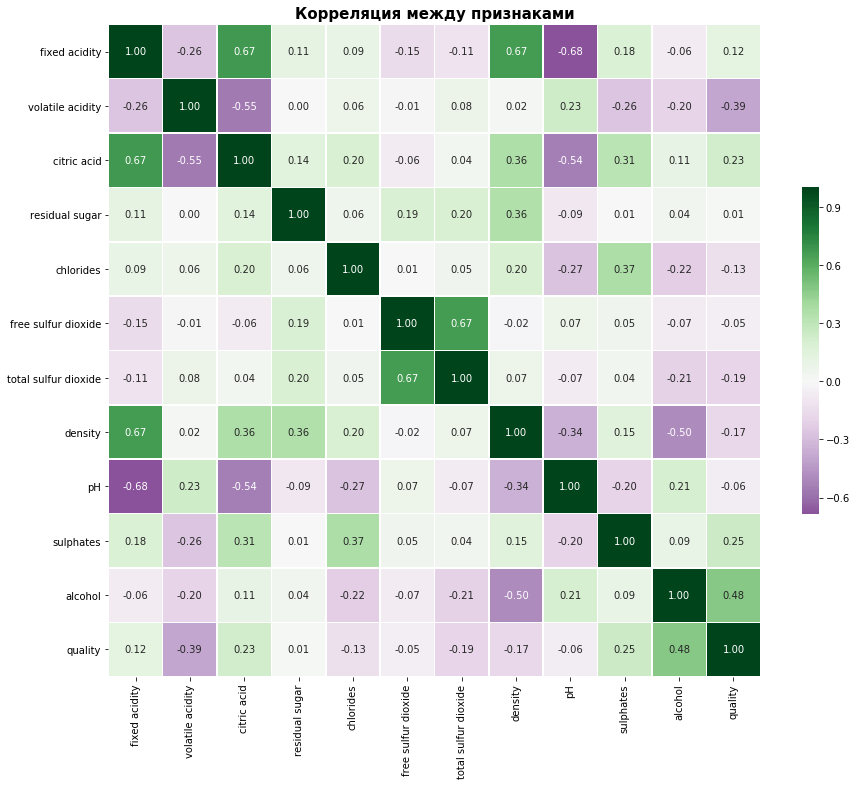

In [13]:
plt.figure(figsize=(15,12))
corr = dataset.corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(12, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [28]:
feature_names = list(dataset.columns)
feature_names.pop(-1)
feature_names

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [61]:
#Restore the rc params from Matplotlib's internal default style
plt.rcdefaults()

## Важность критериев 

### Создание копии, где качество будет бинарной величиной, 1 при >6, иначе 0

In [29]:
_dataset = dataset.copy()
_dataset.loc[dataset['quality'] > 6, "quality"] = 1
_dataset.loc[dataset['quality'] <= 6, "quality"] = 0
_dataset.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Расчёты

In [30]:
_x, _y = _dataset.iloc[:,:-1], _dataset.iloc[:,-1]

Text(0.5, 1.0, 'Univariate score ($-Log(p_{value})$)')

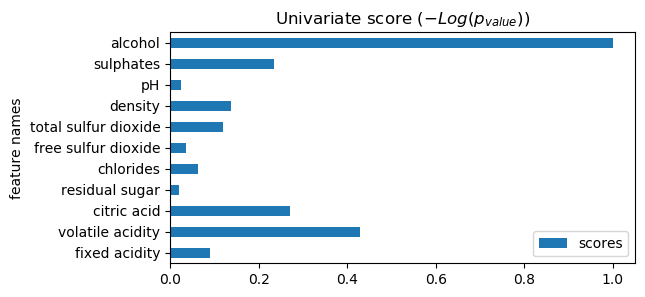

In [34]:
#Использование F-statictics для определения важности критериев
from sklearn.feature_selection import f_classif
f, pval = f_classif(_x, _y)
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py
scores = -np.log10(pval)
scores /= scores.max()
X_indices = np.arange(_x.shape[-1])
df_to_plot = pd.DataFrame({'feature names':feature_names, 'scores':scores})
df_to_plot.plot.barh(x='feature names', y='scores', figsize=(6, 3))
plt.title(r'Univariate score ($-Log(p_{value})$)')

Text(0.5, 1.0, 'RandomForestClassifier feature importances')

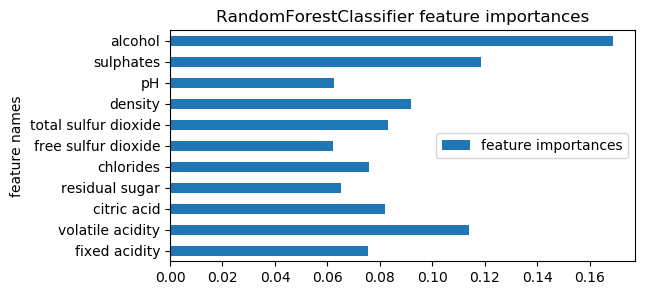

In [37]:
#Использование Random Forest для определения важности критериев
#Это лучше для данной цели, чем boosted models, так как последние игнорируют некоторые переменные полностью
forest = RandomForestClassifier()
forest.fit(_x, _y)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'feature importances':forest.feature_importances_})
df_to_plot.plot.barh(x='feature names', y='feature importances', figsize=(6, 3))
plt.title('RandomForestClassifier feature importances')

Text(0.5, 1.0, 'Permutation feature importance')

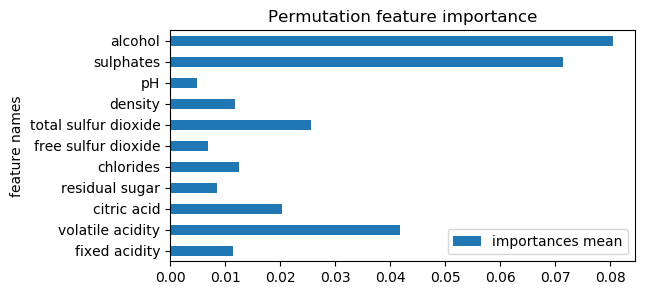

In [38]:
#На сайте sklearn была рекомендация использовать это
from sklearn.inspection import permutation_importance
result = permutation_importance(forest, _x, _y, n_repeats=10, random_state=0)
df_to_plot = pd.DataFrame({'feature names':feature_names, 'importances mean':result.importances_mean})
df_to_plot.plot.barh(x='feature names', y='importances mean', figsize=(6, 3))
plt.title('Permutation feature importance')

## Обучение и предсказание

### Масштрабирование

In [5]:
x, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]

In [48]:
scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, random_state=5)

### Модели

In [7]:
def show_results(estimator, X_train, X_test, y_train, y_test, dataset_scaled, y):
    estimatorScores = cross_val_score(estimator, dataset_scaled, y)
    print("\nРезультат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    estimator.fit(X_train, y_train)
    estimator_pred = estimator.predict(X_test)
    print('\nMAE: {:.4f}'.format(mean_absolute_error(y_test, estimator_pred)))
    print('RMSE: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, estimator_pred))))   
    #print('R2 {:.4f}'.format(r2_score(y_test, estimator_pred)))
    return estimator

In [11]:
def grid_search(estimator, param_grid, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(estimator, param_grid)
    grid_search.fit(X_train, y_train)
    print("Правильность на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
    print("Наилучшие значения параметров: {}".format(grid_search.best_params_))

#### Naive Bayes

In [15]:
param_grid = {'alpha': [0.1, 0.5, 1, 10, 100]}
grid_search(BernoulliNB() ,param_grid , X_train, X_test, y_train, y_test)

Правильность на тестовом наборе: 0.58
Наилучшие значения параметров: {'alpha': 100}


In [16]:
bernoulliNB = show_results(BernoulliNB(alpha=100), X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.4625     0.515625   0.603125   0.56875    0.57680251]
Средняя правильность перекрестной проверки: 0.545

MAE: 0.4850
RMSE: 0.7810


In [22]:
gaussianNB = show_results(GaussianNB(), X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.49375    0.4625     0.5875     0.496875   0.57053292]
Средняя правильность перекрестной проверки: 0.522

MAE: 0.5075
RMSE: 0.7984


#### Tree ensembles

In [18]:
param_grid = {'n_estimators': [10, 30, 50, 70, 100]}
grid_search(ExtraTreesClassifier() ,param_grid , X_train, X_test, y_train, y_test)

Правильность на тестовом наборе: 0.70
Наилучшие значения параметров: {'n_estimators': 70}


In [19]:
extraTreesClassifier = show_results(ExtraTreesClassifier(n_estimators=70), X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.496875   0.56875    0.615625   0.584375   0.59561129]
Средняя правильность перекрестной проверки: 0.572

MAE: 0.3550
RMSE: 0.6595


In [20]:
param_grid = {'n_estimators': [10, 30, 50, 70, 100], 'loss': ['deviance', 'exponential']}
grid_search(GradientBoostingClassifier(init = ExtraTreesClassifier()) ,param_grid , X_train, X_test, y_train, y_test)

Правильность на тестовом наборе: 0.70
Наилучшие значения параметров: {'loss': 'deviance', 'n_estimators': 70}


In [21]:
estimator = GradientBoostingClassifier(init = ExtraTreesClassifier(), n_estimators=70, loss='deviance')
boostedExtraTrees = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.546875  0.578125  0.621875  0.575     0.5862069]
Средняя правильность перекрестной проверки: 0.582

MAE: 0.3350
RMSE: 0.6595


#### Support Vector Classification

In [40]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search(LinearSVC(dual=False) ,param_grid , X_train, X_test, y_train, y_test)

Правильность на тестовом наборе: 0.61
Наилучшие значения параметров: {'C': 0.1}


In [35]:
print('penalty L1')
linearSVC = show_results(LinearSVC(C = 0.1, dual=False, penalty = 'l1'), X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.534375  0.5       0.6125    0.6       0.5862069]
Средняя правильность перекрестной проверки: 0.567

MAE: 0.4400
RMSE: 0.7314


In [50]:
print('penalty L2')
linearSVC = show_results(LinearSVC(C = 0.1, dual=False, penalty = 'l2'), X_train, X_test, y_train, y_test, x_scaled, y)

penalty L2

Результат перекрестной проверки: [0.53125    0.5        0.609375   0.6        0.59247649]
Средняя правильность перекрестной проверки: 0.567

MAE: 0.4375
RMSE: 0.7399


#### Linear Discriminant Analysis

In [42]:
param_grid = {'solver': ['svd', 'lsqr', 'eigen'], 'shrinkage': ['auto', None]}
grid_search(LinearDiscriminantAnalysis() ,param_grid , X_train, X_test, y_train, y_test)

Правильность на тестовом наборе: 0.61
Наилучшие значения параметров: {'shrinkage': 'auto', 'solver': 'lsqr'}


In [43]:
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
lda = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)


Результат перекрестной проверки: [0.5375     0.546875   0.621875   0.603125   0.59561129]
Средняя правильность перекрестной проверки: 0.581

MAE: 0.4425
RMSE: 0.7500


#### Logistic Regression

penalty L1

Результат перекрестной проверки: [0.525      0.53125    0.634375   0.596875   0.63009404]
Средняя правильность перекрестной проверки: 0.584

MAE: 0.4400
RMSE: 0.7416


Text(0.5, 1.0, 'LogisticRegression L1')

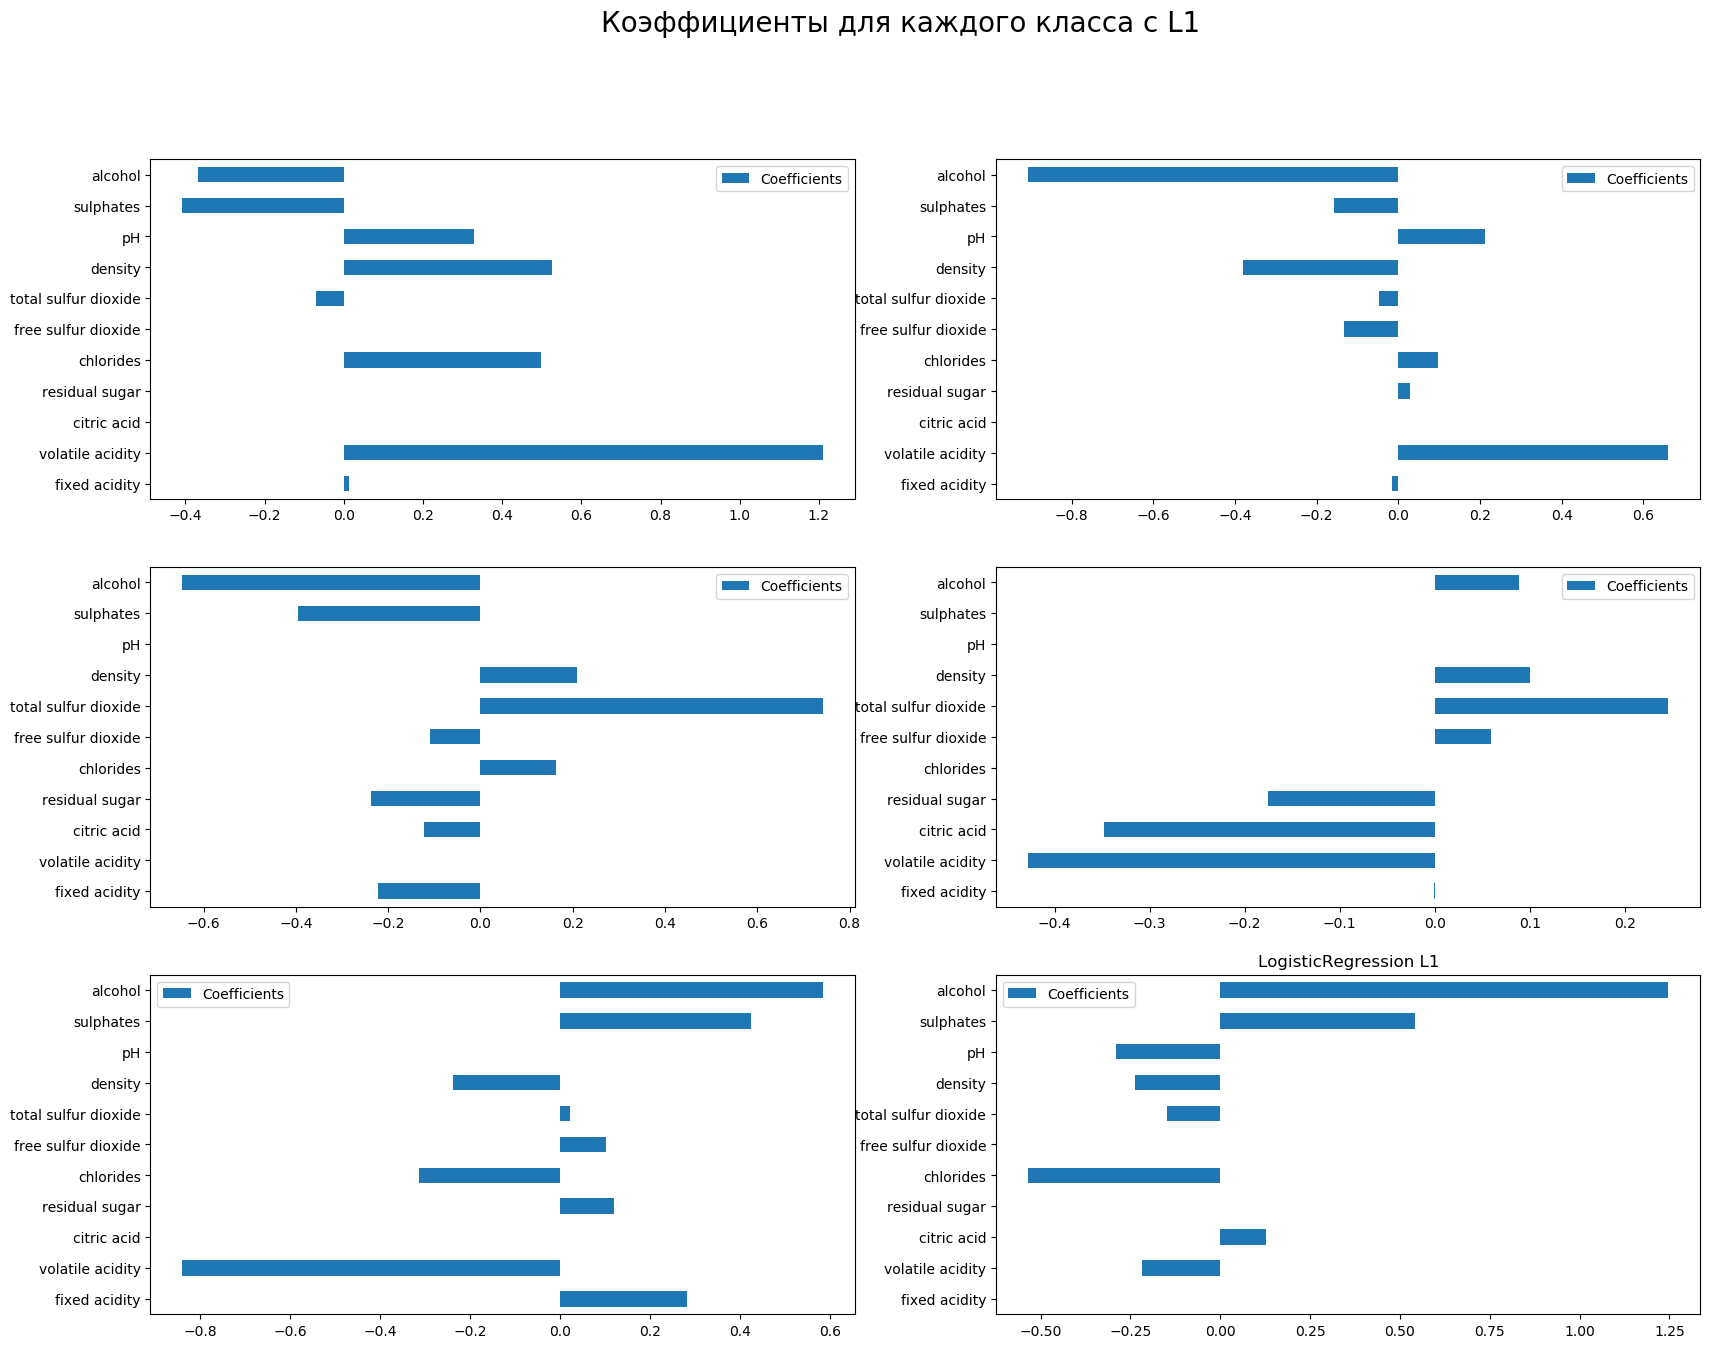

In [72]:
print('penalty L1')
estimator = LogisticRegression(penalty="l1", solver='saga', multi_class='multinomial')
log_l1 = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)

f, axes = plt.subplots(3, 2, figsize=(20, 15))
f.suptitle("Коэффициенты для каждого класса с L1", size=20)
coefs_ = []
for i in range(log_l1.coef_.shape[0]):
    coefs_.append(pd.DataFrame(
        log_l1.coef_[i].reshape(len(feature_names),1),
        columns=['Coefficients'], index=feature_names
    ))

coefs_[0].plot(kind='barh', ax=axes[0,0])
coefs_[1].plot(kind='barh', ax=axes[0,1])
coefs_[2].plot(kind='barh',  ax=axes[1,0])
coefs_[3].plot(kind='barh',  ax=axes[1,1])
coefs_[4].plot(kind='barh',  ax=axes[2,0])
coefs_[5].plot(kind='barh',  ax=axes[2,1])

penalty L2

Результат перекрестной проверки: [0.51875    0.5375     0.63125    0.590625   0.63009404]
Средняя правильность перекрестной проверки: 0.582

MAE: 0.4375
RMSE: 0.7399


Text(0.5, 1.0, 'LogisticRegression L1')

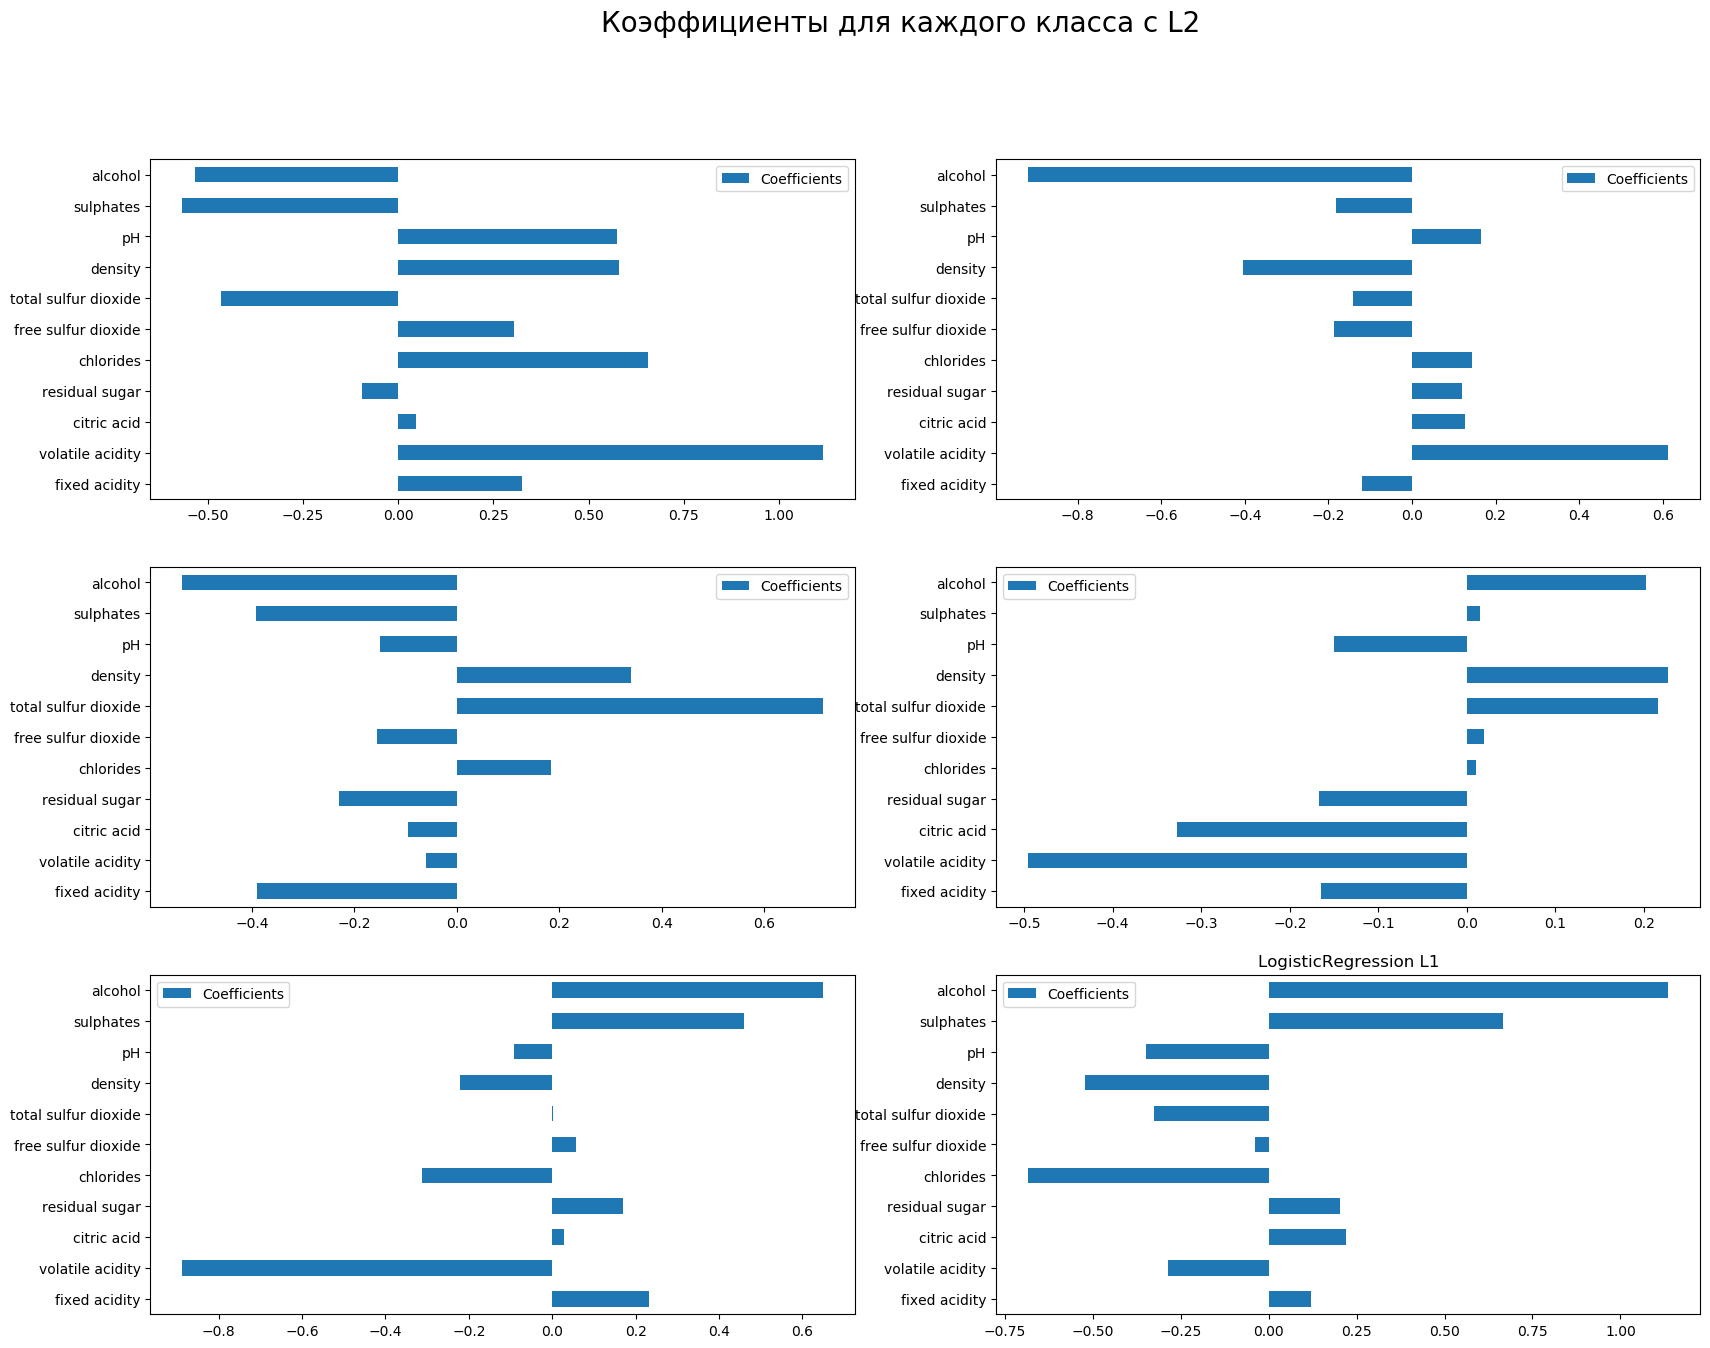

In [73]:
print('penalty L2')
estimator = LogisticRegression(penalty="l2", solver='saga', multi_class='multinomial')
log_l2 = show_results(estimator, X_train, X_test, y_train, y_test, x_scaled, y)

f, axes = plt.subplots(3, 2, figsize=(20, 15))
f.suptitle("Коэффициенты для каждого класса с L2", size=20)
coefs_ = []
for i in range(log_l1.coef_.shape[0]):
    coefs_.append(pd.DataFrame(
        log_l2.coef_[i].reshape(len(feature_names),1),
        columns=['Coefficients'], index=feature_names
    ))

coefs_[0].plot(kind='barh', ax=axes[0,0])
coefs_[1].plot(kind='barh', ax=axes[0,1])
coefs_[2].plot(kind='barh',  ax=axes[1,0])
coefs_[3].plot(kind='barh',  ax=axes[1,1])
coefs_[4].plot(kind='barh',  ax=axes[2,0])
coefs_[5].plot(kind='barh',  ax=axes[2,1])

In [55]:
print('penalty elasticnet')
'''
Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. 
'''
param_grid = {'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
estimator = LogisticRegression(penalty="elasticnet", solver='saga', multi_class='multinomial')
grid_search(estimator, param_grid , X_train, X_test, y_train, y_test)

penalty elasticnet
Правильность на тестовом наборе: 0.61
Наилучшие значения параметров: {'l1_ratio': 1}
